## Field Rotation Calculator

When doing astrophotography with an alt-azimuth mount, objects will rotate as they move across the sky. They will rotate at different rates depending on where the object is in the sky, and the latitude of the observer.

Check changes for GIT

This tool allows you to specify a location, date and object (deep sky only), then plots the following:
- A background showing the field rotation across the sky in degrees per hour at the chosen location
- The path of the chosen object across the sky, starting from midday on the chosen date.

This allows you to plan the best time for photographing that object.

The equations for calculating the field rotation are taken from here: [RASC Calgary Centre - Field Rotation with an Alt-Az Telescope Mount](https://calgary.rasc.ca/field_rotation.htm):

> K = Observer's Constant = Angular Rate of Rotation of the Earth (degrees/hour) × cos(Observer's latitude) <br>
> = 15.04106858 degrees/hour × cos(Observer's latitude) <br>
> (15.04106858 degrees/hour = 360° / hours in a Sidereal day) <br>
> <br>
> Then field rotation for an object currently at azimuth $Az_{object}$ and altitude $Alt_{object}$ is given by: <br>
> <br>
> $\text{Field rotation (deg/hr)} = K  \frac {cos(\text{Az}_{object})} {cos(Alt_{object})}$
> <br>
> <br>



Locations of objects are calculated using the [SIMBAD Astronomical database](https://simbad.u-strasbg.fr/simbad/) via the [Astroquery package](https://astroquery.readthedocs.io/en/latest/#) for [Astropy](https://docs.astropy.org/en/stable/index.html).


### Initialisation
Here we specify any libraries we need and any default paramters.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time,TimeDelta
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
import astropy.units as u
from astropy.table import Table
from astroquery.simbad import Simbad
from timezonefinder import TimezoneFinder
import pytz
import datetime

plt.rcParams['figure.figsize'] = [10, 7]

### Functions
This section contains function modules for doing the calculations and plots

#### Get a list of times for the observations
This returns an Astropy table with 24 rows containing the local times starting at the given time and date in first column and the equivalent Astropy UTC time in the second column

In [4]:
def generate_time_series(location, start_datetime):
    # Initialize TimezoneFinder and find the timezone
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=location.lat.degree, lng=location.lon.degree)
    if timezone_str is None:
        raise ValueError("Could not determine the timezone for the given location.")

    # Create a timezone object
    timezone = pytz.timezone(timezone_str)
    print(timezone_str)
    
    # Ensure start_datetime is naive before localization
    if start_datetime.tzinfo is not None:
        start_datetime = start_datetime.replace(tzinfo=None)
    
    # Localize start_datetime to the given timezone
    start_datetime_local = timezone.localize(start_datetime)
    
    # Generate local and UTC times
    times_local_tz = []
    times_utc = []
    for i in range(24):
        # Calculate local time with timezone
        local_time = start_datetime_local + datetime.timedelta(hours=i)
        times_local_tz.append(local_time)
        
        # Convert local time to UTC and create an Astropy Time object
        utc_time = Time(local_time.astimezone(pytz.utc))
        times_utc.append(utc_time)

    # Create a table to hold the results
    results_table = Table([times_local_tz, times_utc], names=('Local Time', 'Astropy Time (UTC)'))
    
    return results_table

#### Get the altitudes and azimuths for the observer
Returns the same table, but with azimuth and altitude of the chosen object added

In [5]:
def track_object(earth_location, times_table, object_code):
    # Query the object's coordinates from Simbad
    result_table = Simbad.query_object(object_code)
    if result_table is None:
        raise ValueError(f"Object {object_code} not found in Simbad database.")
    
    object_ra = result_table['RA'][0]  # Right Ascension
    object_dec = result_table['DEC'][0]  # Declination

    # Convert RA and DEC from string to degrees
    coord = SkyCoord(f"{object_ra} {object_dec}", unit=('hourangle', 'deg'))

    # Prepare columns for azimuth and altitude
    azimuths = []
    altitudes = []

    # Calculate azimuth and altitude for each UTC time
    for utc_time in times_table['Astropy Time (UTC)']:
        # Convert UTC time to AltAz coordinate system
        altaz = coord.transform_to(AltAz(obstime=utc_time, location=earth_location))
        azimuths.append(altaz.az)
        altitudes.append(altaz.alt)

    # Append azimuth and altitude to the table
    times_table['Azimuth'] = azimuths
    times_table['Altitude'] = altitudes

    # Filter out rows where altitude is less than zero
    visible_rows = times_table['Altitude'] > 0
    filtered_table = times_table[visible_rows]

    return filtered_table

#### Get field rotation
This function gives a figure for field rotation in degrees per hour, using a given altitude, azimuth and observers latitude.

In [6]:
def calculate_field_rotation_deg_per_hour(azimuth, altitude, latitude):
    """
    Calculate the field rotation in degrees per hour.

    Parameters:
    - azimuth (float): Azimuth of the object in degrees, measured from North towards East.
    - altitude (float): Altitude of the object in degrees, above the horizon.
    - latitude (float): Latitude of the observer in degrees.

    Returns:
    - float: Field rotation in degrees per hour.
    """
    # Convert angles from degrees to radians for calculation
    az = np.radians(azimuth)
    alt = np.radians(altitude)
    Lat = np.radians(latitude)
    R_earth_rad = np.radians(15.04106858)

    # Observers constant
    K = R_earth_rad * np.cos(Lat)

    # Calculate the field rotation angle per hour
    phi_rad = K * np.cos(az) / np.cos(alt)

    # Convert the result back to degrees
    phi_deg = np.degrees(phi_rad)

    return phi_deg

#### Plot the field rotation and object
This function plots the field rotation for a given latitude as a background contour grid, with an overlay of the chosen object in hourly intervals

In [7]:
def plot_field_rotation_and_object(earth_location,astropy_table, object_name):
    # Generate a grid of azimuth and altitude values
    azimuth_grid, altitude_grid = np.meshgrid(np.linspace(0, 360, 520), np.linspace(0, 90, 180))

    latitude = earth_location.lat.degree

    # Calculate field rotation across the grid
    field_rotation_grid = calculate_field_rotation_deg_per_hour(azimuth_grid, altitude_grid, latitude)
    field_rotation_grid_clipped = np.abs((np.clip(field_rotation_grid,-60,60)))
    # Plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    colors_rgb = np.array([
        [0, 128, 0],
        [102, 204, 0],
        [255, 255, 0],
        [255, 191, 0],
        [255, 128, 0],
        [255, 0, 0]
    ]) / 255.0

    c = ax.contourf(np.radians(azimuth_grid), 90-altitude_grid, field_rotation_grid_clipped, levels=[0,2,5,10,20,80], colors=colors_rgb,alpha=0.3)

    #c = ax.contour(np.radians(azimuth_grid), 90-altitude_grid, field_rotation_grid_clipped, levels=[1,2,5,7.5,8,10,20])


    # Add a color bar to indicate levels of field rotation
    plt.colorbar(c, ax=ax, orientation='vertical', label='Field Rotation in deg/hour')

    # Label the contour lines
    #ax.clabel(c, inline=True, fontsize=5)

    # Set labels for cardinal directions
    ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    # Altitude rings to display
    altitude_rings = [15, 30, 45, 60, 75]

    # Convert altitude degrees to zenith distance for plotting
    # The plot's radius corresponds to zenith distance: 0 at the zenith and 90 at the horizon
    zenith_distances = [90 - altitude for altitude in altitude_rings]

    # Set the y-ticks to represent these zenith distances
    ax.set_yticks(zenith_distances)

    # Optionally, if you want to label the rings with their corresponding altitudes, you can do so:
    ax.set_yticklabels([f'{altitude}°' for altitude in altitude_rings], fontsize=10)

    # Plot formatting
    ax.set_theta_zero_location('N')
    #ax.set_theta_direction(-1)
    ax.set_ylim(0, 90)

    # Next we'll add the positions of the object 
    # Extract azimuth (convert to radians if necessary), altitude, and local time
    azimuth = np.radians(astropy_table['Azimuth'])  # Converting degrees to radians if needed
    altitude = 90 - astropy_table['Altitude']  # Use directly or transform
    local_times = astropy_table['Local Time']

    ax.plot(azimuth, altitude, 'o-', color='blue', markerfacecolor='red', markeredgecolor='red', linewidth=0.5)

    # Define an offset for the labels' radial distance
    radial_offset = -5  # Adjust as needed for your plot scale

    # Label each point with the hour from the local time, adjusting label position radially
    for az, alt, local_time in zip(azimuth, altitude, local_times):
        hour_label = f"{local_time.hour:02d}h"  # Extract hour and format as 'XXh'
        # Offset the altitude (radial distance) for label positioning
        label_alt = alt + radial_offset
        ax.text(az, label_alt, hour_label, color='black', horizontalalignment='center', verticalalignment='center',fontsize=8)

    # Add some title info
    # Example data
    start_date = f"{local_times[0].day}-{local_times[0].month:02d}-{local_times[0].year}"
    
    # Adding text outside the plot area at the top
    info_text = f"Object: {object_name} \n Start Date: {start_date} \n Latitude: {earth_location.lat.degree:.2f}, Longitude: {earth_location.lon.degree:.2f}"
    plt.suptitle(info_text, fontsize=12, y=1.001)

    # Adjust layout to make room for the suptitle
    plt.tight_layout()

    plt.show()

    return

#### Title for plot
This function attempts to get the common name of the object, and returns the code and common name if one is found, otherwise only the code is returned

In [8]:
def get_common_name(object_code):
    # Add the field for querying common names
    Simbad.add_votable_fields('ids')
    
    # Perform the query
    result = Simbad.query_object(object_code)
    
    if result is None:
        return f"No results found for {object_code}."
    
    # Extract the 'IDS' column which contains identifiers including the common name
    ids = result['IDS'][0].split('|')
    
    # Find common names, heuristic: common names don't contain numbers or are well-known acronyms
    common_names = [name for name in ids if not any(char.isdigit() for char in name)]
    
    if common_names:
        # Remove the "NAME" prefix if present
        common_name = common_names[0].replace("NAME ", "")
        return f"{object_code} ({common_name})"
    else:
        return object_code

#### Main function
This function calls the plotting function, which outputs the plot, and returns a nicely formatted table that can be displayed if wanted

In [9]:
def show_field_rotation_and_object(earth_location,start_datetime, object_code):
    
    times_list = generate_time_series(earth_location, start_datetime)

    observing_info = track_object(earth_location, times_list, object_code)

    plot_field_rotation_and_object(earth_location,observing_info,get_common_name(object_code))

    # Create a new table for nice display if user wants it.
    # First get the field rotation in deg/hour
    field_rotation_values = [calculate_field_rotation_deg_per_hour(azimuth, altitude, earth_location.lat.degree)
                            for azimuth, altitude in zip(observing_info['Azimuth'],observing_info['Altitude'])]

    observing_info['Field Rotation'] = field_rotation_values
    
    # Create the output table
    output_table = Table()

    output_table['Local time'] = observing_info['Local Time']
    output_table['UTC time'] = observing_info['Astropy Time (UTC)']
    output_table['Azimuth'] = np.round(observing_info['Azimuth'],2)
    output_table['Altitude'] = np.round(observing_info['Altitude'],2)
    output_table['Field Rotation'] = np.round(observing_info['Field Rotation'],2)

    return output_table

### Main program code
Here we set our location and start time, and call the main functions

Europe/London


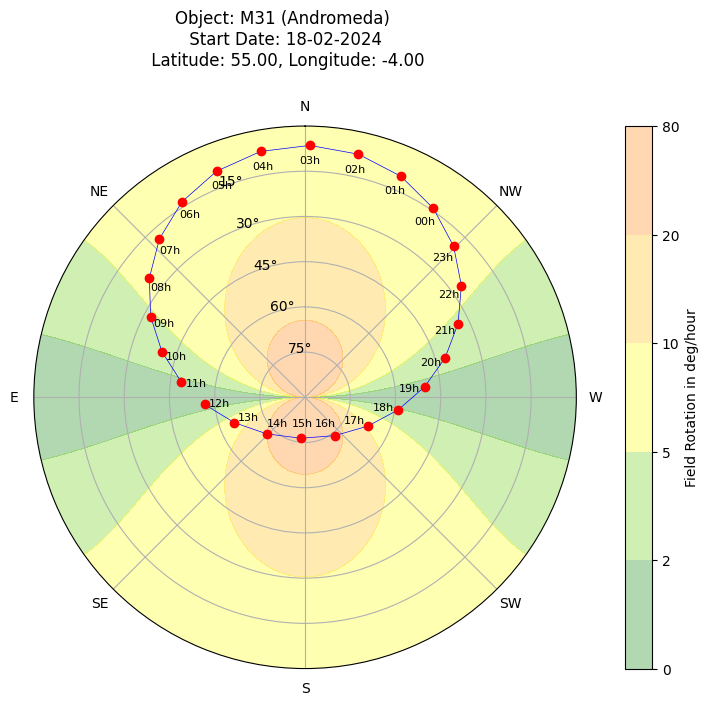

idx,Local time,UTC time,Azimuth,Altitude,Field Rotation
0,2024-02-18 12:00:00+00:00,2024-02-18 12:00:00,94.1,56.6,-1.12
1,2024-02-18 13:00:00+00:00,2024-02-18 13:00:00,109.61,65.03,-6.86
2,2024-02-18 14:00:00+00:00,2024-02-18 14:00:00,133.58,72.41,-19.68
3,2024-02-18 15:00:00+00:00,2024-02-18 15:00:00,173.86,76.34,-36.33
4,2024-02-18 16:00:00+00:00,2024-02-18 16:00:00,217.84,73.89,-24.56
5,2024-02-18 17:00:00+00:00,2024-02-18 17:00:00,245.35,67.08,-9.24
6,2024-02-18 18:00:00+00:00,2024-02-18 18:00:00,262.39,58.8,-2.21
7,2024-02-18 19:00:00+00:00,2024-02-18 19:00:00,275.01,50.19,1.18
8,2024-02-18 20:00:00+00:00,2024-02-18 20:00:00,285.74,41.72,3.14
9,2024-02-18 21:00:00+00:00,2024-02-18 21:00:00,295.73,33.67,4.5


In [12]:
observer = EarthLocation(lat=55.0, lon=-4) # Latitude and longitude of observer
start_datetime = datetime.datetime(2024, 2, 18, 12, 0, 0)  # Start date and time of observation

observing_info = show_field_rotation_and_object(observer,start_datetime,"M31")

observing_info.show_in_notebook()